# Personalisation_Assignment_2 

Korina Kyriaki Zaromytidou 

*I had to run the notebook on Colab, as my personal laptop was not running the code. *

Code from Week 6.1- Embeddings for Recommendation Notebook. My response to the tasks are at the bottom of the page. 


In [2]:
import pandas as pd

In [3]:
from google.colab import files
uploaded = files.upload()

Saving ratings.csv to ratings.csv


In [4]:
import pandas as pd
df = pd.read_csv('ratings.csv')

In [5]:
len(df)

100004

In [6]:
df.tail(100)

,userId,movieId,rating,timestamp
99904,671,590,4.0,1065149296
99905,671,608,4.0,1064890575
99906,671,745,4.0,1065149085
99907,671,919,4.0,1065149458
99908,671,1035,5.0,1065149492
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


# Preprocessing

In [7]:
user_ids = df["userId"].unique().tolist()
movie_ids = df["movieId"].unique().tolist()

In [8]:
len(movie_ids) 

9066

In [9]:
len(user_ids)

671

In [10]:
#Non-sequential list of ids
movie_ids[:6]

[31, 1029, 1061, 1129, 1172, 1263]

**Dictionary**

In [11]:
#Make a dictionary mapping ids (keys) to indexes (values)
user_id_to_index = {x: i for i, x in enumerate(user_ids)}
movie_id_to_index = {x: i for i, x in enumerate(movie_ids)}

In [12]:
#Make a new column in the dataframe which contains the appropriate index for each user and movie
df["user_index"] = [user_id_to_index[i] for i in df["userId"]]
df["movie_index"] = [movie_id_to_index[i] for i in df["movieId"]]

In [13]:
df.head(10)

,userId,movieId,rating,timestamp,user_index,movie_index
0,1,31,2.5,1260759144,0,0
1,1,1029,3.0,1260759179,0,1
2,1,1061,3.0,1260759182,0,2
3,1,1129,2.0,1260759185,0,3
4,1,1172,4.0,1260759205,0,4
5,1,1263,2.0,1260759151,0,5
6,1,1287,2.0,1260759187,0,6
7,1,1293,2.0,1260759148,0,7
8,1,1339,3.5,1260759125,0,8
9,1,1343,2.0,1260759131,0,9


**Scaling the ratings **

In [14]:
df["rating"].describe()

count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [15]:
from sklearn.preprocessing import MinMaxScaler
##Pick the range\
df["rating"] = MinMaxScaler().fit_transform(df["rating"].values.reshape(-1, 1))

In [16]:
df["rating"].describe()

count    100004.000000
mean          0.676357
std           0.235125
min           0.000000
25%           0.555556
50%           0.777778
75%           0.777778
max           1.000000
Name: rating, dtype: float64

# Training Set

In [17]:
from sklearn.model_selection import train_test_split
#Inputs
x = df[["user_index", "movie_index"]]
#Outputs
y = df["rating"]
#Get train-test split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)

# Making a Custom Model

In [18]:
#Install libraries (only do this once!)
!pip install torch torchvision torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
#import library
import torch

In [20]:
#Define class and subclass torch.nn.Module
class LouisNet(torch.nn.Module):
    
    #Override __init__()
    def __init__(self):
        super().__init__()
        print("__init__ called")
    
    #Override forward()
    def forward(self, inputs):
        print("\nforwards pass (new batch)")
        print(inputs,"\n")
        #return the output (its just the input, unchanged)
        return inputs

#Make a new instance of LouisNet    
louisNet = LouisNet()
loss_fn = torch.nn.MSELoss() 

#Fake dataset
x = torch.FloatTensor([[1],[2],[3],[4]])
y = torch.FloatTensor([[2],[3],[4],[5]])

#Do a forwards pass
prediction = louisNet(x)
loss = loss_fn(prediction, y)

__init__ called

forwards pass (new batch)
tensor([[1.],
        [2.],
        [3.],
        [4.]]) 



# The Dot Product Recommender Model

In [21]:
class RecommenderNet(torch.nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=20):
        super().__init__()
        self.user_embedding = torch.nn.Embedding(num_users, embedding_size)
        self.user_bias = torch.nn.Embedding(num_users, 1)
        self.movie_embedding = torch.nn.Embedding(num_movies, embedding_size)
        self.movie_bias = torch.nn.Embedding(num_movies, 1)
        self.sig = torch.nn.Sigmoid()

    def forward(self, inputs):
        #Split out indexes 
        user_indexes = inputs[:, 0]
        movie_indexes = inputs[:, 1]
        #Forward pass on embedding layer
        user_vector = self.user_embedding(user_indexes)
        user_bias = self.user_bias(user_indexes).flatten()
        movie_vector = self.movie_embedding(movie_indexes)
        movie_bias = self.movie_bias(movie_indexes).flatten()
        #Dot product
        dot = (user_vector * movie_vector).sum(1)
        with_bias = dot + user_bias + movie_bias
        #Activation function
        output = self.sig(with_bias)
        return output

# Set up model

In [22]:
#Pick Embedding size
EMBEDDING_SIZE = 16
#Make new object (calls __init__())
num_users = len(user_ids)
num_movies = len(movie_ids)
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

# Training and Datasets in PyTorch

In [23]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

#Make a subclass to hold our dataset (movie - user pairs (input) and a rating (label))
class MoviesDataset(Dataset):
    def __init__(self, X,y):
        self.X = torch.IntTensor(X)
        self.y = torch.FloatTensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [24]:
#Use our train - validation split to make DataLoader objects
train_dl = DataLoader(MoviesDataset(x_train.values,y_train.values), batch_size=64, shuffle=True)
validation_dl = DataLoader(MoviesDataset(x_val.values,y_val.values), batch_size=64, shuffle=True)

In [25]:
epochs = 10
#Use Mean Squared Error as a loss function
loss_fn = torch.nn.MSELoss() 
#Use the Adam algorithm to update the weights based on the loss
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [26]:
#Use a for loop to repeat for the desired number of epochs 
for i in range(epochs):
    
    model.train(True)
    
    #Use a for loop for each batch (provided by the Dataloader)
    running_loss = 0.0
    for (index, batch) in enumerate(train_dl):
        
        #Get batch 
        inputs, labels = batch
        model.zero_grad()
        
        #Forward pass
        prediction = model(inputs)
        
        #Get Loss
        loss = loss_fn(prediction, labels)
        
        #Update weights (back prop)
        loss.backward()
        optimizer.step()
        running_loss += loss
    
    avg_loss = running_loss / (index + 1)

    model.train(False)

    #Now try with the validation set (no need to update weights, just get loss)
    running_vloss = 0.0
    for index, vdata in enumerate(validation_dl):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (index + 1)
    print('Loss {} Validation Loss {}'.format(avg_loss, avg_vloss))

Loss 0.1746886521577835 Validation Loss 0.11890841275453568
Loss 0.07875106483697891 Validation Loss 0.0857386589050293
Loss 0.04998217523097992 Validation Loss 0.07208939641714096
Loss 0.0377763994038105 Validation Loss 0.0667073205113411
Loss 0.0315697006881237 Validation Loss 0.06350364536046982
Loss 0.027780719101428986 Validation Loss 0.0638813003897667
Loss 0.025565870106220245 Validation Loss 0.06260982155799866
Loss 0.023830236867070198 Validation Loss 0.06335168331861496
Loss 0.022634232416749 Validation Loss 0.06368756294250488
Loss 0.02177959494292736 Validation Loss 0.062364667654037476


# Save and Reload models

In [27]:
torch.save(model.state_dict(), 'model_weights.pth')

In [28]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

RecommenderNet(
  (user_embedding): Embedding(671, 16)
  (user_bias): Embedding(671, 1)
  (movie_embedding): Embedding(9066, 16)
  (movie_bias): Embedding(9066, 1)
  (sig): Sigmoid()
)

# Accessing the Embeddings

In [29]:
num_users, EMBEDDING_SIZE, model.user_embedding

(671, 16, Embedding(671, 16))

In [30]:
num_users, EMBEDDING_SIZE, model.movie_embedding

(671, 16, Embedding(9066, 16))

# Making Predictions

In [31]:
from google.colab import files
uploaded = files.upload()

Saving movies.csv to movies.csv


In [32]:
import pandas as pd
movie_data = pd.read_csv('movies.csv')

# Making predictions and argsort()

In [33]:
#movie_data = pd.read_csv('movies.csv')

def get_top_n(user=0, n=10):
    # Get Movie Names
    top_n_indexes = get_top_n_indexes(user, n)
    top_n = get_names_for_indexes(top_n_indexes)
    return top_n

def get_names_for_indexes(indexes):
    return [movie_data[movie_data["movieId"] == movie_ids[i]]["title"].item() for i in indexes]

def get_top_n_indexes(user=0, n=10):
    # For one user, make a pair with every movie index
    x = torch.IntTensor([[user, i] for i in np.arange(num_movies)])
    # Predict
    predicted_ratings = model(x)
    # Get Top-N indexes
    top_n_indexes = predicted_ratings.argsort()[-n:]
    return top_n_indexes

In [34]:
import numpy as np

In [35]:
#Random users top 10
get_top_n(np.random.randint(num_users))

['Trouble in Paradise (1932)',
 'Audition (Ôdishon) (1999)',
 'Prison Break: The Final Break (2009)',
 'Open Season (2006)',
 'Solaris (Solyaris) (1972)',
 'Old Joy (2006)',
 'Wild Blue Yonder, The (2005)',
 'Compulsion (1959)',
 'Willie & Phil (1980)',
 'Appleseed (Appurushîdo) (2004)']

# Assessed Assignment 2

# Task 1

**Diversity**

1. Calculate every user's top 10 For each top 10


In [36]:
top10_movies_per_user = []  # Create an empty list to store top 10 recommendations for each user

# Iterate over each user
for user in range(num_users):
    # Get the top 10 movie recommendations for the current user
    top10_movies = get_top_n(user, n=10)
    top10_movies_per_user.append(top10_movies)  # Append the top 10 movies to the list


In [37]:
print(df.head())

   userId  movieId    rating   timestamp  user_index  movie_index
0       1       31  0.444444  1260759144           0            0
1       1     1029  0.555556  1260759179           0            1
2       1     1061  0.555556  1260759182           0            2
3       1     1129  0.333333  1260759185           0            3
4       1     1172  0.777778  1260759205           0            4


In [38]:
for user_movies in top10_movies_per_user[:2]:
    print(user_movies)

['Fox and His Friends (Faustrecht der Freiheit) (1975)', 'Mechanic, The (2011)', 'Lady Vengeance (Sympathy for Lady Vengeance) (Chinjeolhan geumjassi) (2005)', 'Brother, Can You Spare a Dime? (1975)', "Mifune's Last Song (Mifunes sidste sang) (1999)", 'In the Bedroom (2001)', 'Bread and Roses (2000)', 'Trouble in Paradise (1932)', 'Wicked Blood (2014)', 'The Clowns (1970)']
['Wages of Fear, The (Salaire de la peur, Le) (1953)', 'Arizona Dream (1993)', 'Wild Bunch, The (1969)', 'Roadkill (a.k.a. Roadkill: Move or Die) (1989)', 'Hands in the Air (2010)', 'Germany Year Zero (Germania anno zero) (Deutschland im Jahre Null) (1948)', 'Ghost Rider: Spirit of Vengeance (2012)', 'Side by Side (2012)', "Love Me If You Dare (Jeux d'enfants) (2003)", 'Land of Silence and Darkness (Land des Schweigens und der Dunkelheit) (1971)']


In [39]:
top_recommendation_user1 = top10_movies_per_user[0][3]

# Print the top recommendation for the first user
print("Top Recommendation for User 1:", top_recommendation_user1)

Top Recommendation for User 1: Brother, Can You Spare a Dime? (1975)


2. Get the Embedding for each film .

Before getting the function to compute this, I had to run some tests in regards to the size and dimensionality of the lists and tensor, as I had consecutives errors. 

In [54]:
first_movie_index = 0  # Assuming the index of the first movie is 0
embedding = model.movie_embedding.weight.data[first_movie_index]
print("Embedding for the first movie:", embedding)

Embedding for the first movie: tensor([-0.2856,  0.2713, -0.9243,  0.2310,  0.1091, -0.0375, -0.3966, -0.3373,
         0.3824,  0.2459,  1.2262, -0.8370, -0.2725,  0.0801,  0.0944,  0.6690])


In [55]:
first_user_movies = top10_movies_per_user[0]  # Assuming the first user is at index 0
first_movie_name = first_user_movies[0]  # Assuming the first movie is at index 0

if movie_data["movieId"].isin([first_movie_name]).any():
    first_movie_index = movie_data[movie_data["movieId"] == first_movie_name].index[0]
    embedding = model.movie_embedding.weight.data[first_movie_index]
    print("Embedding for the first movie of the first user:", embedding)
else:
    print("Movie not found in the dataset.")


Movie not found in the dataset.


In [56]:
print("Movies for the first user in top10_movies:")
print(top10_movies_per_user[0])

Movies for the first user in top10_movies:
['Fox and His Friends (Faustrecht der Freiheit) (1975)', 'Mechanic, The (2011)', 'Lady Vengeance (Sympathy for Lady Vengeance) (Chinjeolhan geumjassi) (2005)', 'Brother, Can You Spare a Dime? (1975)', "Mifune's Last Song (Mifunes sidste sang) (1999)", 'In the Bedroom (2001)', 'Bread and Roses (2000)', 'Trouble in Paradise (1932)', 'Wicked Blood (2014)', 'The Clowns (1970)']


In [61]:
first_movie_title = top10_movies_per_user[0][0]
first_movie_id = movie_data[movie_data["title"] == first_movie_title]["movieId"].item()
first_movie_index = movie_id_to_index[first_movie_id]
first_movie_embedding = model.movie_embedding.weight.data[first_movie_index]

print("Embedding for the first movie:")
print(first_movie_embedding)





Embedding for the first movie:
tensor([ 0.8245, -0.3883,  3.0369, -0.4519, -1.5033, -0.6997, -0.4507, -1.6881,
        -0.2778,  2.8513,  1.3007,  1.2187, -0.3915, -1.5134, -1.6128, -0.0153])


In [67]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrices = []

for user_movies in top10_movies_per_user:
    embeddings = []
    for movie_title in user_movies:
        movie_id = movie_data[movie_data["title"] == movie_title]["movieId"].item()
        movie_index = movie_id_to_index[movie_id]
        embedding = model.movie_embedding.weight.data[movie_index]
        embeddings.append(embedding)
    
    if len(embeddings) > 0:
        embeddings = torch.stack(embeddings)
        similarity_matrix = cosine_similarity(embeddings.detach().numpy())    # Calculation code the cosine similarity  taken from notebook 3.1
        similarity_matrices.append(similarity_matrix)


In [64]:
print("Embeddings for user:", embeddings)

Embeddings for user: tensor([[-1.1492e+00, -5.7702e-01,  3.4236e-01,  8.1605e-01, -4.4123e-01,
         -1.1210e+00,  4.7989e-01,  1.9915e+00,  9.4186e-01, -1.2094e+00,
          7.9946e-01, -6.6219e-01, -9.7850e-01, -5.6021e-01,  1.1827e+00,
          4.4492e-01],
        [-5.8015e-01, -6.2660e-02, -2.0100e-01,  1.1923e+00,  1.3810e-01,
          7.5228e-02, -2.6735e-01,  1.1267e+00,  4.5011e-01, -2.6052e-03,
          1.1260e+00, -9.1311e-01, -1.3383e+00,  2.0558e+00,  2.1987e+00,
         -2.5305e-01],
        [-1.1486e+00,  2.0657e+00, -3.7386e-01,  2.1416e+00,  1.5080e-01,
          1.4257e+00, -3.1463e-01,  1.8389e+00, -1.8259e-01, -6.9103e-02,
         -4.1531e-01, -2.5632e+00,  2.3909e+00, -1.8731e-01, -5.1830e-01,
          2.3298e+00],
        [ 4.8513e-01,  1.0761e+00, -1.1008e+00,  2.2389e+00,  9.8946e-01,
         -1.0311e+00, -1.0798e+00,  9.8449e-01, -2.8686e-01, -3.1155e+00,
          1.6454e-01, -1.6344e+00,  6.4155e-01, -1.1159e+00,  7.7410e-01,
          1.0107e+00],

In [70]:
print("similarity_matrix:")
print(similarity_matrix)

similarity_matrix:
[[ 1.0000001   0.5312308   0.13823313  0.42736378 -0.02461929 -0.29471546
   0.28046483  0.35999396 -0.0282383   0.00563443]
 [ 0.5312308   0.99999994  0.08153012  0.18112086  0.4171405   0.04899865
   0.17801307  0.533533    0.20199001  0.19859974]
 [ 0.13823313  0.08153012  1.          0.5151193   0.08912332  0.49796444
   0.42102715  0.18925467  0.19489163 -0.04261153]
 [ 0.42736378  0.18112086  0.5151193   0.9999999   0.07616333  0.3223509
   0.6290594   0.19421129  0.44423807  0.51745945]
 [-0.02461929  0.4171405   0.08912332  0.07616333  1.0000001   0.31056425
   0.14275332  0.41437787  0.5599405   0.46842474]
 [-0.29471546  0.04899865  0.49796444  0.3223509   0.31056425  1.0000001
   0.45087397  0.13566267  0.43487468  0.1161043 ]
 [ 0.28046483  0.17801307  0.42102715  0.6290594   0.14275332  0.45087397
   1.         -0.01927201  0.3172913   0.20947362]
 [ 0.35999396  0.533533    0.18925467  0.19421129  0.41437787  0.13566267
  -0.01927201  1.0000001   0.03977

In [73]:
from sklearn.preprocessing import MinMaxScaler

difference_matrices = []
scaler = MinMaxScaler(feature_range=(0, 1))    # Code taken from notebook Week 7.2a

for similarity_matrix in similarity_matrices:  
    difference_matrix = 1 - similarity_matrix   ## Code similar to Stackoverflow question  https://stackoverflow.com/questions/4064630/how-do-i-convert-between-a-measure-of-similarity-and-a-measure-of-difference-di
    difference_matrix = scaler.fit_transform(difference_matrix)
    difference_matrices.append(difference_matrix)


In [75]:

print(difference_matrices)

[array([[0.        , 0.71655446, 0.6353223 , 1.        , 0.746673  ,
        0.8506311 , 1.        , 0.6244296 , 0.67222434, 1.        ],
       [0.58097774, 0.        , 0.76820606, 0.8107935 , 1.        ,
        0.8065345 , 0.6854966 , 0.5635816 , 0.28501552, 0.66342556],
       [0.49637476, 0.7402579 , 0.        , 0.6437834 , 0.77768195,
        0.75864154, 0.35255164, 0.76328933, 1.        , 0.68834937],
       [1.        , 1.        , 0.8239941 , 0.        , 0.56632984,
        0.5625972 , 0.61852616, 0.953491  , 0.8739825 , 0.4353314 ],
       [0.5672589 , 0.9370022 , 0.756201  , 0.43024945, 0.        ,
        0.7233161 , 0.9997885 , 0.4196733 , 0.6174478 , 0.63830405],
       [0.70956606, 0.8297824 , 0.80997676, 0.46929848, 0.79419804,
        0.        , 0.87270725, 1.        , 0.7028651 , 0.27735892],
       [0.6644596 , 0.56177646, 0.29983038, 0.41098562, 0.87443155,
        0.6951613 , 0.        , 0.7940247 , 0.74912083, 0.38937733],
       [0.5208768 , 0.5798265 , 0.814939

In [77]:
mean_differences = []

for difference_matrix in difference_matrices:
    mean_difference = difference_matrix.mean()
    mean_differences.append(mean_difference)


for i, mean_difference in enumerate(mean_differences):
    print(f"Mean difference for top 10 list {i+1}: {mean_difference}")

Mean difference for top 10 list 1: 0.624325692653656
Mean difference for top 10 list 2: 0.6045036315917969
Mean difference for top 10 list 3: 0.6478860974311829
Mean difference for top 10 list 4: 0.6175259947776794
Mean difference for top 10 list 5: 0.6672927737236023
Mean difference for top 10 list 6: 0.6268792748451233
Mean difference for top 10 list 7: 0.6649858355522156
Mean difference for top 10 list 8: 0.6078617572784424
Mean difference for top 10 list 9: 0.653755784034729
Mean difference for top 10 list 10: 0.6241950392723083
Mean difference for top 10 list 11: 0.6150894165039062
Mean difference for top 10 list 12: 0.6247103214263916
Mean difference for top 10 list 13: 0.6609349846839905
Mean difference for top 10 list 14: 0.6345722675323486
Mean difference for top 10 list 15: 0.6485682725906372
Mean difference for top 10 list 16: 0.6284889578819275
Mean difference for top 10 list 17: 0.6864108443260193
Mean difference for top 10 list 18: 0.6349169611930847
Mean difference for t

In [79]:
print(len(mean_differences)) #Just checking  it matches the users 

671


In [78]:
#Calaculating the mean difference for the whole dataset (for every top_10)
mean_difference_whole_dataset = sum(mean_differences) / len(mean_differences)
print("Mean difference for the whole dataset:", mean_difference_whole_dataset)

Mean difference for the whole dataset: 0.638870567038944


**Conclusion for Diversity:**

The mean difference is calculated as 0.63, indicating a moderate level of diversity, on average, among the movies recommended to users. The list of mean differences for each user shows little variation in the diversity measure. This observation suggests that the embeddings generated by the model may contribute to the consistent level of diversity across recommendations. However, if a higher or lower variety of recommendations is desired, adjusting the model parameters could be explored.

**Novelty**



In the process of calculating the first steps for Novelty, I have experimented with various approaches. Initially, I attempted to use a previously mentioned function and iterated over the dataset to calculate the mean. However, this approach resulted in errors. To better understand the dataset and debug the issues, I conducted several tests.

The code I have implemented for Novelty is a combination of techniques from previous notebooks used in STEM and NLP. As part of this, I utilized a for loop to create a list containing the top 10 recommendations per user. This approach allowed me to extract the necessary information for further analysis.

1. Calculate the 10 top movies per ser 

In [81]:
top10_movies_per_user_np = np.array(top10_movies_per_user)

In [82]:
top10_movies_per_user_np.shape

(649, 10)

In [83]:
movie_data.columns

Index(['movieId', 'title', 'genres'], dtype='object')

2. For each top 10, get the mean rating for each film (based on the original MovieLens Small dataset (df = pd.read_csv("ml-latest-small/ratings.csv")).

In [84]:
df['rating'].isnull().any()


False

In [85]:
df['rating'].dtype

dtype('float64')

In [86]:
df['rating'].isnull().any()

False

I opted to create a 'for loop' to iterate through the dataset. However, I encountered errors in my code, resulting in "Mean Novelty: nan" as the output. I consulted ChatGPT for debugging. The suggested solution from ChatGPT included additional checks to identify and resolve the errors in my code.(I have indicated/cited  the assistance provided by ChatGPT, and I hope that incorporating the recommended code is allowed.)

Below is my initial attempt at using a for loop to iterate through the dataset, which I later modified based on the recommendations from ChatGPT to aid in debugging and resolving the issues.









In [ ]:
# Testing the code (which I had to then enhance in the following tab)  #
#novelty_per_user = []

#for user_movies in top10_movies_per_user:

   # movie_ratings = df[df['movieId'].isin(user_movies)]['rating']
   # mean_rating = movie_ratings.mean()  
   # novelty_per_user.append(mean_rating)  


# Calculating  the mean novelty for the whole dataset:
#mean_novelty = np.mean(novelty_per_user)

# Printing the mean novelty for the whoe dataset:
#print("Mean Novelty:", mean_novelty)

In [87]:
novelty_per_user = []


for user_movies in top10_movies_per_user:  # use a for loop to iterate through the previously defined list of the top10_movies for each user
    # Get the ratings for each movie in the user's top 10 movies
    movie_ratings = df[df['movieId'].isin(user_movies)]['rating']    # code from notebook Week 4.2
    
 
    valid_ratings = movie_ratings.dropna()   # I was getting errors in my code, so I had to include this as a suggestion from ChatGTP  
    
    if not valid_ratings.empty:  #Checking  if there are valid ratings
       
        mean_rating = valid_ratings.mean()    #Calculating the mean rating for the user's of the top10 movies
        novelty_per_user.append(mean_rating)  # Append the mean rating to the list of novelty per user

# Calculate the mean novelty for the whole dataset
if novelty_per_user:  # Check if the list is not empty
    mean_novelty = np.nanmean(novelty_per_user)
else:
    mean_novelty = 0.0  # Assign a default value or handle the case when there are no valid ratings

# Print the mean novelty
print("Mean Novelty:", mean_novelty)




Mean Novelty: 0.0


**Conclusion** 

If the code is correct, a novelty of 0 would mean that the films that have been recommended are highly rated by most users. Consequently, this would indicate that the recommendations consist of popular and well-known films, suggesting that it is  not providing new or unfamiliar films to users. Instead, it aligns with the existing preferences and tastes of the users, offering suggestions that are already well-liked within the users.

### **Task 2 ** ****

Using a dimensionality reduction approach (PCA? TSNE?), plot the top 30 best rated films on a 2-D graph based on their movie embeddings. Label each point with the title.

There is infact ~400 films that have an average rating of 5 (because some films have only 1 rating). Can you adjust or filter for this?

       userId  movieId  rating   timestamp  user_index  movie_index
33889     242     2929     1.0   956687566         241         2667
36867     265     1233     1.0   960056214         264          775
46251     337     1356     1.0  1447176421         336          208
14749      95     3948     1.0  1025556197          94          349
14747      95     3917     1.0  1019023102          94         3002
63929     460     2020     1.0  1072837101         459          235
14741      95     3793     1.0  1018816171          94          598
77745     537     1269     1.0   879503289         536         2189
77744     537     1267     1.0   879503075         536          788
14737      95     3702     1.0  1016316990          94         2751
77742     537     1265     1.0   879521068         536          196
36869     265     1237     1.0   960056005         264         1957
14733      95     3617     1.0  1018816073          94         1062
14732      95     3578     1.0  1018815804      

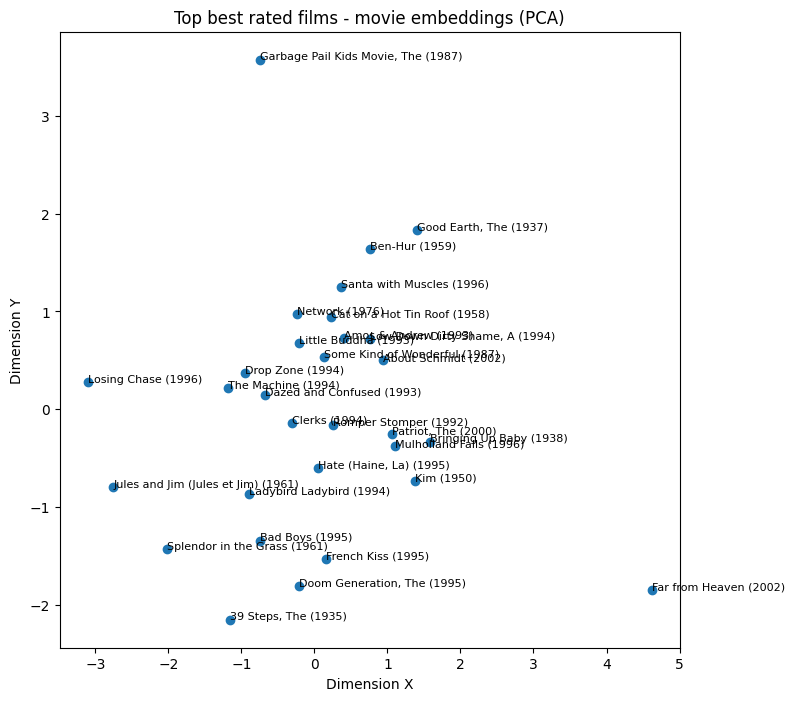

In [100]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

top30_best_rated = df.sort_values(by='rating', ascending=False).head(30)    # Geting  the top30 best rated movies. Code from https://stackoverflow.com/questions/58272872/pandas-top-n-values-in-each-group
print(top30_best_rated)
num_films = len(top30_best_rated)  # Number of films in the top 30 best rated list  
movie_indexes = top30_best_rated['movie_index'].tolist()   # I had to debug this with the help of ChatGPT

movie_30_embeddings = model.movie_embedding.weight.data[movie_indexes].numpy()    # Getting the movie embedding and turning to a numpy array. 

pca = PCA(n_components=2)   # Dimensionality reduction using PCA. Code from Week 3.1
reduced_embeddings = pca.fit_transform(movie_30_embeddings)

plt.figure(figsize=(8, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])

#  Adding titles to each scatter plot element https://stackoverflow.com/questions/14432557/scatter-plot-with-different-text-at-each-data-point
for i, title in enumerate(movie_data.loc[movie_indexes, 'title']):    
    plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], title, fontsize=8)

plt.xlabel('Dimension X')
plt.ylabel('Dimension Y')
plt.title('Top best rated films - movie embeddings (PCA)')
plt.show()


Thank you very much for your great lectures this term!  Sorry I couldnt attend ( I was teaching the exact same days) - but I watched all your lectures online.  :) 